<a href="https://colab.research.google.com/github/brea-koenes/app/blob/main/ProductOutageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Outage Classifier


#### Machine Learning Capstone Project


#### **Author:** Brea Koenes


#### **Date:** August 2025

### 1 - Objective
---
My project is to develop a model that identifies Starbucks customer text mentioning product outages. The intent is to improve Starbucks' understanding of their product outages through customer sentiment data.

### 2 - Import Data
---
There are 2 datasets:

1. **Facebook**: comments about Starbucks from Facebook and Instagram apps
2. **Uber**: reviews on Uber Eats Starbucks orders

**Import libraries and data**

In [ ]:
# Common imports
import os
import re
import nltk
import torch
import string
import numpy as np
import pandas as pd
from google.colab import drive

# Connect to Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import data
path = '/content/drive/My Drive/Data/'
facebook = pd.read_csv(path+'Facebook.csv')
uber = pd.read_csv(path+'UberEats.csv')

### 3 - Exploratory Data Analysis


---

Based on a manual review of the datasets, about 1.5% of customer text, also referred to as posts, are about product outages.

The datasets' posts are futher analyzed on:

*   Row count
*   Nulls
*   Duplicates
*   Max character count





**Display data**

In [ ]:
from IPython.display import Markdown, display

# Display one sample post from Facebook
display(Markdown(" ##### Facebook Sample Post"))
display(Markdown(f"> {facebook['Text'].dropna().sample(1).iloc[0]}"))

# Display one sample post from Uber Eats
display(Markdown(" ##### Uber Eats Sample Post"))
display(Markdown(f"> {uber['Text'].dropna().sample(1).iloc[0]}"))

 ##### Facebook Sample Post

> Alexandra Nguyen join now https://facebook.com/groups/################/

 ##### Uber Eats Sample Post

> did not get this item

**Summary statistics**

In [ ]:
# Add new columns to ensure correct labels
facebook['source'] = 'Facebook'
uber['source'] = 'Uber Eats'

# Combine datasets
combined_df = pd.concat([facebook, uber], ignore_index = True)
summary_data_combined = []

In [ ]:
# Output summary statistics for each source
for source_name in combined_df['source'].unique():

    # Define and calculate information displayed
    df = combined_df[combined_df['source'] == source_name]
    char_count = df['Text'].astype(str).apply(len)
    null_count = df['Text'].isnull().sum()
    duplicate_count = df['Text'].duplicated().sum()

    summary_data_combined.append({
        'Source': source_name,
        'Rows': len(df),
        'Duplicates': duplicate_count,
        'Nulls': null_count,
        'Max Char. Count': char_count.max(),
    })

# Display statistics
summary_df_combined = pd.DataFrame(summary_data_combined)
display(summary_df_combined)

,Source,Rows,Duplicates,Nulls,Max Char. Count
0,Facebook,76037,1790,0,10510
1,Uber Eats,84055,22091,114,5776


The 2 datasets have similar row counts. There are many duplicate rows in the Uber Eats dataset. There are also nulls in the Uber Eats dataset. Facebook tends to have longer posts.

**Visualizations**

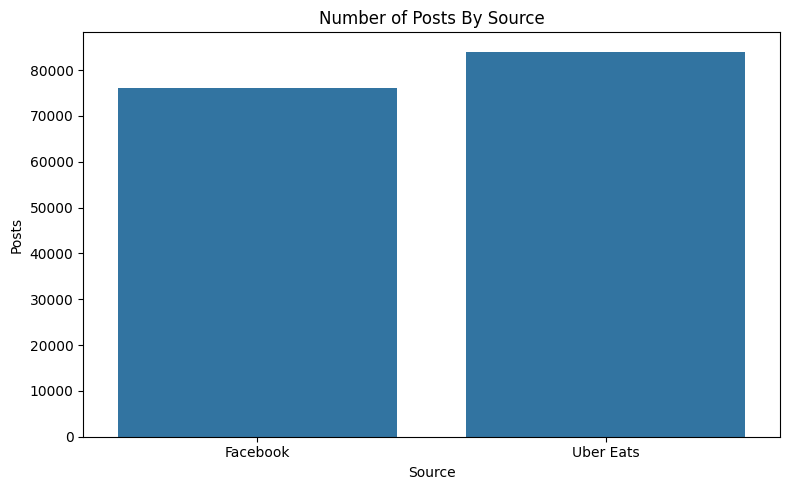

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count posts per source
source_counts = combined_df['source'].value_counts().reset_index()

# Plot number of posts per source
plt.figure(figsize=(8,5))
sns.countplot(data=combined_df, x='source')
plt.title('Number of Posts By Source')
plt.xlabel('Source')
plt.ylabel('Posts')
plt.tight_layout()
plt.show()

Number of posts per dataset is quite similar, with slightly more data from the Uber Eats source.

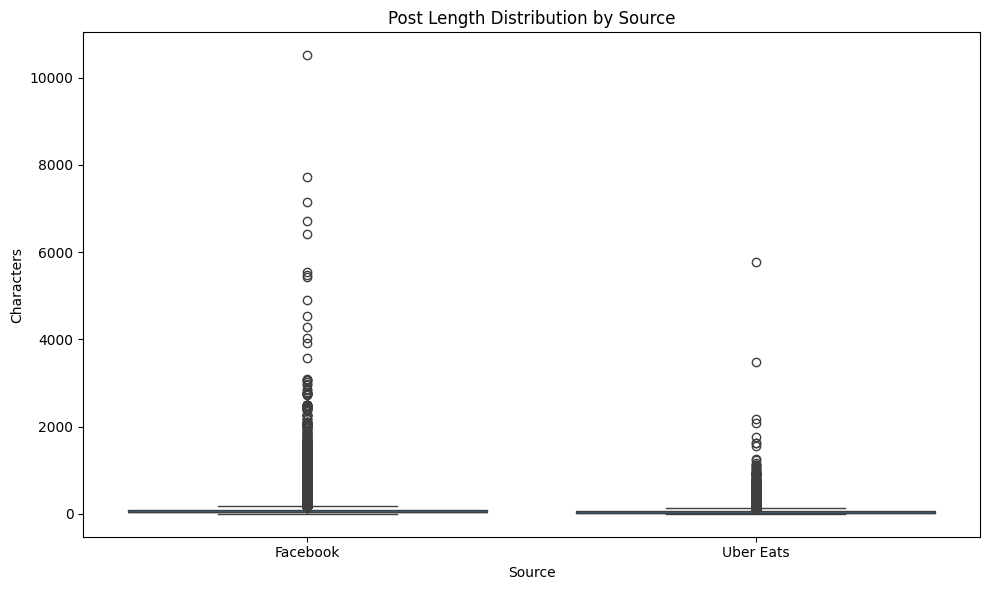

In [ ]:
# Calculate character count of posts
combined_df['char_count'] = combined_df['Text'].astype(str).apply(len)

# Boxplot of post length by souce
plt.figure(figsize=(10,6))
sns.boxplot(data=combined_df, x='source', y='char_count')
plt.title('Post Length Distribution by Source')
plt.ylabel('Characters')
plt.xlabel('Source')
plt.tight_layout()

Facebook's post length has longerer posts, but both have several substantially long posts.

### 4 - Data Preparation and Cleaning

---

Based on the data exploration, the following is needed:

*   Basic cleaning
*   Sampling for training and test sets
*   Manual labeling

**Basic cleaning**

In [ ]:
# Drop NAs and duplicates in posts
combined_df = combined_df.dropna(subset=['Text']).drop_duplicates(subset='Text')

# Trim post length
combined_df['Text'] = combined_df['Text'].apply(lambda x: x[:1000])

NAs and duplicates are dropped from both sets. Lengthy posts are trimmed.

**Sample into test and training sets**

In [ ]:
# Define product outage-related keywords
keywords = [
    "unavailable", "not available", "out of stock", "out of", "problem", "never have",
    "didn't have", "run out", "ran out", "sold out", "restock"
]

# Lowercase for keyword matching
combined_df['text_lower'] = combined_df['Text'].fillna('').str.lower()

# Flag rows with any keyword
pattern = '|'.join(keywords)
combined_df['is_keyword_hit'] = combined_df['text_lower'].str.contains(pattern, na=False)

# Define parameters
posts_per_source = 2000          # 2000 posts per source
train_fraction = 0.8             # 80% train, 20% test split
train_outage_fraction = 0.4      # 40% outage keyword posts in training set

train_samples = []
test_samples = []

# For each source, sample into training and test sets
for source, group in combined_df.groupby('source'):

    # Preserve original index for tracking
    group = group.reset_index()

    # Set number of posts for training and test
    n_train = int(posts_per_source * train_fraction)
    n_test = posts_per_source - n_train

    # Split keyword hits and non-hits
    keyword_hits = group[group['is_keyword_hit']].reset_index(drop=True)
    non_keyword_hits = group[~group['is_keyword_hit']].reset_index(drop=True)

    # Sample test set first to ensure it is distinct
    test_sample = group.sample(n=n_test, random_state=42)
    test_indices = test_sample['index'].values

    # Exclude test indices from the group for training
    train_pool = group[~group['index'].isin(test_indices)]

    # Split train pool into keyword hits and non-hits
    train_keyword_hits = train_pool[train_pool['is_keyword_hit']]
    train_non_keyword_hits = train_pool[~train_pool['is_keyword_hit']]

    n_outage_train = int(n_train * train_outage_fraction)
    n_non_outage_train = n_train - n_outage_train

    # Sample outage-like posts for training
    if len(train_keyword_hits) < n_outage_train:
        outage_train_sample = train_keyword_hits.copy()
        # Adjust non-outage sample size accordingly
        n_non_outage_train = n_train - len(outage_train_sample)
        non_outage_train_sample = train_non_keyword_hits.sample(n=n_non_outage_train, random_state=42)
    else:
        outage_train_sample = train_keyword_hits.sample(n=n_outage_train, random_state=42) # Outage posts
        non_outage_train_sample = train_non_keyword_hits.sample(n=n_non_outage_train, random_state=42) # Non-outage posts

    # Combine and shuffle training samples
    train_sample = pd.concat([outage_train_sample, non_outage_train_sample]).sample(frac=1, random_state=42)
    train_samples.append(train_sample)
    test_samples.append(test_sample)

# Combine all sources
train_df = pd.concat(train_samples).reset_index(drop=False).rename(columns={'index': 'original_index'}) # Keep original index
test_df = pd.concat(test_samples).reset_index(drop=False).rename(columns={'index': 'original_index'}) # Keep original index

# Drop helper columns before manual labeling
train_df = train_df.drop(columns=['text_lower', 'is_keyword_hit'])
test_df = test_df.drop(columns=['text_lower', 'is_keyword_hit'])

# Add empty manual label columns
train_df['Label'] = ''
test_df['Label'] = ''

cols_to_export = ['Text', 'Label', 'original_index'] # Include original_index for tracking

# Save files for manual labeling
drive_path = '/content/drive/My Drive/'
os.makedirs(drive_path, exist_ok=True)

train_df.to_excel(drive_path + 'manual_label_train.xlsx', index=False, columns=cols_to_export)
test_df.to_excel(drive_path + 'manual_label_test.xlsx', index=False, columns=cols_to_export)

# Print rows for validation
print(f"Training set rows: {len(train_df)}")
print(f"Test set rows: {len(test_df)}")

Training set rows: 3200
Test set rows: 800


The data is sampled and split to be manually labeled. The training set is oversampled with product outage posts since since they are rare. This will give the model enough outage posts to be able to identify them in the test set.

**Read in manually labeled data**

In [ ]:
# Read in manually labeled datasets
path = '/content/drive/My Drive/Labeled_Data/'

train = pd.read_excel(path+'labeled_train.xlsx')
test = pd.read_excel(path+'labeled_test.xlsx')

The posts are manual labeled as product outage (1) or not product outage (0) with the guidence of domain experts when needed. The labeled sets are read back in.

### 5 - Feature Engineering


---



3 sets of feature representations are created. These will be used to find the optimal representation for our model.

1. **TF-IDF:** Represents text based on frequency of words
2. **BERT:** Represents text using pre-trained BERT model, capturing contextual relationships
3. **Combined:** TF-IDF and BERT combined

**TF-IDF features**

In [ ]:
# Imports for gensim phraser; requires different numpy version
!pip uninstall -q numpy
!pip install -q gensim

Proceed (Y/n)? Y
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# Run this cell from earlier in the notebook as runtime will restart
import re
import string
import nltk
import torch
import numpy as np
import pandas as pd
from google.colab import drive

# Read in manually labeled datasets
drive.mount('/content/drive')
path = '/content/drive/My Drive/Labeled_Data/'

train = pd.read_excel(path+'labeled_train.xlsx')
test = pd.read_excel(path+'labeled_test.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create TF-IDF features
import gensim
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.phrases import Phrases, Phraser

# Downloads
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Tokenize and Clean
def preprocess_text_for_phrasing(text):
    text = str(text).lower()                                                               # Lowercase
    text = re.sub(r'http\S+', '', text)                                                    # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))                       # Remove punctuation
    tokens = word_tokenize(text)                                                           # Tokenize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]  # Lemmatize and remove stop words
    return tokens

# Apply preprocessing
train_tokens = train['Text'].apply(preprocess_text_for_phrasing)
test_tokens = test['Text'].apply(preprocess_text_for_phrasing)

# Apply phraser
phrases = Phrases(train_tokens,
                  min_count=3,    # 3 is min. times phrase must appear
                  threshold=2)    # 2 is min. score required for phrases
phraser = Phraser(phrases)

train_phrased = train_tokens.apply(lambda tokens: phraser[tokens])
test_phrased = test_tokens.apply(lambda tokens: phraser[tokens])

# Rejoin tokens for TF-IDF
train['Text_tfidf'] = train_phrased.apply(lambda tokens: ' '.join(tokens))
test['Text_tfidf'] = test_phrased.apply(lambda tokens: ' '.join(tokens))

# TF-IDF vecotrization
tfidf_vectorizer = TfidfVectorizer(max_features=2700,            # Limit to 2700 terms
                                   min_df=2,                     # Exclude if in fewer than 2
                                   max_df=0.85,                  # Exclude if in over 85%
                                   ngram_range=(1, 1))           # Set to 1 ngram due to using Gensim Phraser

# Fit/transform
X_train_tfidf = tfidf_vectorizer.fit_transform(train['Text_tfidf']).toarray()
X_test_tfidf = tfidf_vectorizer.transform(test['Text_tfidf']).toarray()

# Print shape for validation
print(f"TF-IDF training features shape: {X_train_tfidf.shape}")
print(f"TF-IDF test features shape: {X_test_tfidf.shape}")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


TF-IDF training features shape: (3200, 2651)
TF-IDF test features shape: (800, 2651)


The text is preprocessed and cleaned of noise. Gensim Phraser is used to capture meaning of phrases, then TF-IDF vectorization is applied.

**BERT embeddings**

In [ ]:
# Create BERT embeddings
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import StandardScaler

# Remove depreciation notice
import warnings
warnings.filterwarnings("ignore", message=".*encoder_attention_mask.*")

# Load pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')  # Optimal BERT model chosen
model = AutoModel.from_pretrained('bert-base-uncased')

# Use CPU
device = torch.device('cpu')
model.to(device)
model.eval()

# Generate BERT [CLS] embeddings for a list of tests
def get_bert_embeddings(texts, batch_size=16, max_length=128):  # Optimal batch size and max length set

    # Ensure inputs are in correct format, especially function is deployed
    if isinstance(texts, (list, np.ndarray)):
        texts = texts
    elif hasattr(texts, 'tolist'):
        texts = texts.tolist()
    else:
        raise ValueError("Input 'texts' must be a list, numpy array, or pandas Series.")

    all_embeddings = []

    # Generate embeddings in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT embeddings"):
        batch_texts = texts[i:i + batch_size]

        # Tokenize and move directly to device
        encoded = tokenizer(
            batch_texts,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        ).to(device)

        with torch.no_grad():
            outputs = model(**encoded)  # Pass everything at once
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # Using CLS
            all_embeddings.append(cls_embeddings.cpu().numpy())

    return np.concatenate(all_embeddings, axis=0) if all_embeddings else np.array([])

# Generate embeddings
print("Generating train embeddings...")
X_train = get_bert_embeddings(train['Text'])

print("Generating test embeddings...")
X_test = get_bert_embeddings(test['Text'])

# Normalize embeddings
scaler = StandardScaler()
X_train_bert = scaler.fit_transform(X_train)
X_test_bert = scaler.transform(X_test)

# Print shape
print(f"BERT training features shape: {X_train_bert.shape}")
print(f"BERT test features shape: {X_test_bert.shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Generating train embeddings...


Generating BERT embeddings: 100%|██████████| 200/200 [28:16<00:00,  8.48s/it]


Generating test embeddings...


Generating BERT embeddings: 100%|██████████| 50/50 [07:23<00:00,  8.87s/it]

BERT training features shape: (3200, 768)
BERT test features shape: (800, 768)


BERT does not need additional preprocessing as TF-IDF did. Here, the text is tokenized and bert-base-uncased is applied to the data. Embeddings are generated and normalized.

**Combine**

In [ ]:
# Combine features
X_train_combined = np.concatenate((X_train_bert, X_train_tfidf), axis=1)
X_test_combined = np.concatenate((X_test_bert, X_test_tfidf), axis=1)

# Print shape
print(f"Combined training features shape: {X_train_combined.shape}")
print(f"Combined test features shape: {X_test_combined.shape}")

Combined training features shape: (3200, 3419)
Combined test features shape: (800, 3419)


TF-IDF features and BERT embeddings are combined.

**Extract labels**

In [ ]:
# Extract label columns
train_labels = train['Label']
test_labels = test['Label']

Label columns are extracted.

### 6 - Model training


---



Different model types are trained, each using the 3 feature representations. They are tuned with balanced weights and 5-fold cross validation. The top 4 models are selected by F1 score.

A naive classifier is also created to evaluate the baseline for F1.

**Baseline:**
1. Naive, logistic regression
**Model Types:**
1. Logistic regression
2. Support Vector Machine
3. XGBoost
4. LightGBM


**Baseline**

In [ ]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, log_loss, average_precision_score, ConfusionMatrixDisplay

# Create a naive baseline that always predicts the majority class (0)
y_baseline_pred = np.zeros_like(test_labels)

# Evaluate baseline
baseline_accuracy = accuracy_score(test_labels, y_baseline_pred)
baseline_f1_minority = f1_score(test_labels, y_baseline_pred, pos_label=1, zero_division=0)
baseline_precision = precision_score(test_labels, y_baseline_pred, pos_label=1, zero_division=0)
baseline_recall = recall_score(test_labels, y_baseline_pred, pos_label=1, zero_division=0)

# Print classification report
print(classification_report(test_labels, y_baseline_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       788
           1       0.00      0.00      0.00        12

    accuracy                           0.98       800
   macro avg       0.49      0.50      0.50       800
weighted avg       0.97      0.98      0.98       800



The naive logistic regression classifier establishes a baseline by always predicting the majority class (non-outage posts). This model achieves a high accuracy due to the dataset’s imbalance, scoring 0.98, but it assigns a score of 0 for the minority class (outage posts).

Improvements on the F1 score are measured against this baseline of 0.

**Logistic regression**

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate, ParameterGrid

# Define feature representations
features = {
    "TF-IDF": X_train_tfidf,
    "BERT": X_train_bert,
    "Combined": X_train_combined
}

# Setup 5 folds for cross-validation with stratificatiom to preserve class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_results = {}

# Evaluate each feature representation and store metrics
for name, X in features.items():
    lr = LogisticRegression(
        class_weight="balanced",      # Balance weights due to class imbalance
        max_iter=2000,
        random_state=42
    )
    # Perform cross-validation and compute scores for each metrics
    scores = cross_validate(
        lr, X, train_labels,
        cv=skf,
        scoring=["f1", "recall", "precision"],
        n_jobs=-1
    )
    # Store scores for each metric
    lr_results[name] = {
        "f1": np.mean(scores["test_f1"]),
        "recall": np.mean(scores["test_recall"]),
        "precision": np.mean(scores["test_precision"])
    }

# Print full results
for emb, scores in lr_results.items():
    print(f"{emb}: F1={scores['f1']:.4f}, Recall={scores['recall']:.4f}, Precision={scores['precision']:.4f}")

# Find feature representation and print
best_lr_features = max(lr_results, key=lambda k: lr_results[k]["f1"])
print(f"\nBest Features for Logistic Regression: {best_lr_features}")

TF-IDF: F1=0.7583, Recall=0.7550, Precision=0.7621
BERT: F1=0.7170, Recall=0.7566, Precision=0.6821
Combined: F1=0.7185, Recall=0.7533, Precision=0.6875

Best Features for Logistic Regression: TF-IDF


**SVM**

In [ ]:
from sklearn.svm import SVC

svm_results = {}

# Evaluate each feature representation and store metrics
for name, X in features.items():
    svm_clf = SVC(
        kernel='linear',               # Linear kernel for interpretability and speed
        class_weight='balanced',       # Handle class imbalance
        random_state=42
    )
    # Perform cross-validation and compute scores for each metrics
    scores = cross_validate(
        svm_clf, X, train_labels,
        cv=skf,
        scoring=["f1", "recall", "precision"],
        n_jobs=-1
    )
    # Store scores for each metric
    svm_results[name] = {
        "f1": np.mean(scores["test_f1"]),
        "recall": np.mean(scores["test_recall"]),
        "precision": np.mean(scores["test_precision"])
    }

# Print full results
for emb, scores in svm_results.items():
    print(f"{emb}: F1={scores['f1']:.4f}, Recall={scores['recall']:.4f}, Precision={scores['precision']:.4f}")

# Find feature representation and print
best_svm_features = max(svm_results, key=lambda k: svm_results[k]["f1"])
print(f"\nBest Features for SVM: {best_svm_features}")

TF-IDF: F1=0.7443, Recall=0.7668, Precision=0.7241
BERT: F1=0.6937, Recall=0.7332, Precision=0.6584
Combined: F1=0.6885, Recall=0.7248, Precision=0.6558

Best Features for SVM: TF-IDF


**XGBoost**

In [ ]:
import xgboost as xgb

# Calculate class imbalance weight for XGBoost and LightGBM tree-based models
scale_pos_weight = np.sum(train_labels == 0) / np.sum(train_labels == 1)

xgb_results = {}

# Evaluate each feature representation and store metrics
for name, X in features.items():
    xgb_clf = xgb.XGBClassifier(
        random_state=42,
        objective='binary:logistic',
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,  # Balance weights due to class imbalance
        use_label_encoder=False,
        verbosity=0,
        n_jobs=-1
    )
    # Perform cross-validation and compute scores for each metrics
    scores = cross_validate(
        xgb_clf, X, train_labels,
        cv=skf,
        scoring=["f1", "recall", "precision"],
        n_jobs=-1
    )
    # Store scores for each metric
    xgb_results[name] = {
        "f1": np.mean(scores["test_f1"]),
        "recall": np.mean(scores["test_recall"]),
        "precision": np.mean(scores["test_precision"])
    }

# Print full results
for emb, scores in xgb_results.items():
    print(f"{emb}: F1={scores['f1']:.4f}, Recall={scores['recall']:.4f}, Precision={scores['precision']:.4f}")

# Find feature representation and print
best_xgb_features = max(xgb_results, key=lambda k: xgb_results[k]["f1"])
print(f"\nBest Features for XGBoost: {best_xgb_features}")

TF-IDF: F1=0.7319, Recall=0.7247, Precision=0.7401
BERT: F1=0.6271, Recall=0.5268, Precision=0.7754
Combined: F1=0.7227, Recall=0.6358, Precision=0.8397

Best Features for XGBoost: TF-IDF


**LightGBM**

In [ ]:
import lightgbm as lgb
import warnings

# Suppress LightGBM warnings
warnings.filterwarnings("ignore", message=".*X does not have valid feature names.*", category=UserWarning)

lgb_results = {}

# Evaluate each feature representation and store metrics
for name, X in features.items():
    lgb_clf = lgb.LGBMClassifier(
        random_state=42,
        objective="binary",
        metric="None",
        scale_pos_weight=scale_pos_weight,    # Balance weights due to class imbalance
        verbose=-1,
        device="cpu",
        n_jobs=-1
    )
    # Perform cross-validation and compute scores for each metrics
    scores = cross_validate(
        lgb_clf, X, train_labels,
        cv=skf,
        scoring=["f1", "recall", "precision"],
        n_jobs=-1
    )
    # Store scores for each metric
    lgb_results[name] = {
        "f1": np.mean(scores["test_f1"]),
        "recall": np.mean(scores["test_recall"]),
        "precision": np.mean(scores["test_precision"])  # Store precision
    }

# Print full results
for emb, scores in lgb_results.items():
    print(f"{emb}: F1={scores['f1']:.4f}, Recall={scores['recall']:.4f}, Precision={scores['precision']:.4f}")

# Find feature representation and print
best_lgb_features = max(lgb_results, key=lambda k: lgb_results[k]["f1"])
print(f"\nBest Features for LightGBM: {best_lgb_features}")

TF-IDF: F1=0.6685, Recall=0.7063, Precision=0.6363
BERT: F1=0.6265, Recall=0.5251, Precision=0.7824
Combined: F1=0.7596, Recall=0.6560, Precision=0.9025

Best Features for LightGBM: Combined


### 7 - Model tuning


---

Further tuning is done to the 4 best models. This will supplement the prior performance metrics to determine the single best model and the best parameters for the test set.

The following is tuned:
*   Hyperparameters
*   Threshold

Validation set for tuning: while the training dataset is oversampled for training, the tuning should be done on the data's actual distribution (about 1.5% product outages). This ensures the model is not overfit on the oversampled training data and that the tuning targets generalize to realistic conditions.

**Create realistic validation set for tuning**

In [ ]:
from sklearn.model_selection import ParameterGrid

# Function to create a validation set with realistic class balance
def create_validation_set(X, y, val_size=0.2, pos_ratio=0.015, random_state=42):
    # Set random seed for reproducibility
    np.random.seed(random_state)

    # Find indices for positive and negative classes
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == 0)[0]

    # Calculate number of samples for validation set
    total_val_samples = int(len(X) * val_size)
    pos_val_samples = max(1, int(total_val_samples * pos_ratio))
    neg_val_samples = total_val_samples - pos_val_samples

    # Ensure more samples than available aren't requested
    pos_val_samples = min(pos_val_samples, len(pos_indices))
    neg_val_samples = min(neg_val_samples, len(neg_indices))

    # Randomly select validation indices
    val_pos_idx = np.random.choice(pos_indices, size=pos_val_samples, replace=False)
    val_neg_idx = np.random.choice(neg_indices, size=neg_val_samples, replace=False)

    # Combine positive and negative indices for validation set
    val_indices = np.concatenate([val_pos_idx, val_neg_idx])
    train_indices = np.setdiff1d(np.arange(len(X)), val_indices)

    return train_indices, val_indices

# Function to tune model hyperparameters
def tune_hyperparameters(model_class, param_grid, X, y, train_idx, val_idx, base_params=None):
    best_score = -1
    best_params = None
    best_model = None

    # Get training and validation data
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]

    # Try each combination of parameters
    for params in ParameterGrid(param_grid):
        if base_params:
            params = {**base_params, **params}

        # Train model and evaluate
        model = model_class(**params)
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_val)[:, 1]
        score = average_precision_score(y_val, y_prob)

        # Update best model if score improves
        if score > best_score:
            best_score = score
            best_params = params
            best_model = model

    return best_model, best_params, best_score

# Function to find best threshold for predictions
def tune_threshold(model, X, y, train_idx, val_idx, thresholds=np.arange(0.1, 0.9, 0.05)):
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]

    # Train model and get predictions
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_val)[:, 1]

    best_threshold = 0.5
    best_f1 = 0
    best_metrics = {}

    # Try different thresholds
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        if len(np.unique(y_pred)) > 1:  # Check for valid predictions
            f1 = f1_score(y_val, y_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
                best_metrics = {
                    'f1': f1,
                    'precision': precision_score(y_val, y_pred),
                    'recall': recall_score(y_val, y_pred)
                }

    return best_threshold, best_metrics

# Set parameters for validation set
val_size = 0.2
pos_ratio = 0.015
random_state = 42

# Create validation sets for TF-IDF (Logistic Regression and XGBoost)
train_idx_tfidf, val_idx_tfidf = create_validation_set(X_train_tfidf, train_labels, val_size, pos_ratio, random_state)
print(f"TF-IDF Validation Set: {len(val_idx_tfidf)} samples, Positive Ratio: {np.mean(train_labels[val_idx_tfidf]):.4f}")

# Create validation set for Combined (LightGBM)
train_idx_combined, val_idx_combined = create_validation_set(X_train_combined, train_labels, val_size, pos_ratio, random_state)
print(f"Combined Validation Set: {len(val_idx_combined)} samples, Positive Ratio: {np.mean(train_labels[val_idx_combined]):.4f}")

# Calculate new class weights for imbalanced data
scale_pos_weight = np.sum(train_labels == 0) / np.sum(train_labels == 1)
scale_pos_weight_adjusted = scale_pos_weight * (pos_ratio / (np.sum(train_labels == 1) / len(train_labels)))
print(f"\nClass Weights: Original={scale_pos_weight:.2f}, Adjusted={scale_pos_weight_adjusted:.2f}")

TF-IDF Validation Set: 640 samples, Positive Ratio: 0.0141
Combined Validation Set: 640 samples, Positive Ratio: 0.0141

Class Weights: Original=4.37, Adjusted=0.35


**Tune Logistic Regression with TF-IDF**


Best Logistic Regression Parameters: {'class_weight': {0: 1, 1: 0.35187604161974684}, 'max_iter': 1000, 'random_state': 42, 'C': 10, 'penalty': 'l2'}
Best Logistic Regression Threshold: 0.300
F1: 0.4444, Precision: 0.3333, Recall: 0.6667
Log Loss: 0.0666


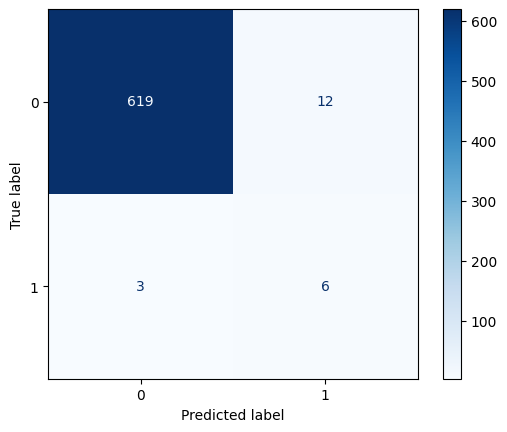

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tune Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}
lr_base_params = {
    'class_weight': {0: 1, 1: scale_pos_weight_adjusted},
    'max_iter': 1000,
    'random_state': 42
}
best_lr_model, best_lr_params, best_lr_score = tune_hyperparameters(
    LogisticRegression, lr_param_grid, X_train_tfidf, train_labels, train_idx_tfidf, val_idx_tfidf, lr_base_params
)
print(f"\nBest Logistic Regression Parameters: {best_lr_params}")

# Tune threshold for Logistic Regression
lr_threshold, lr_metrics = tune_threshold(best_lr_model, X_train_tfidf, train_labels, train_idx_tfidf, val_idx_tfidf)
print(f"Best Logistic Regression Threshold: {lr_threshold:.3f}")
print(f"F1: {lr_metrics['f1']:.4f}, Precision: {lr_metrics['precision']:.4f}, Recall: {lr_metrics['recall']:.4f}")

# Get validation predictions with the best threshold
val_preds_proba = best_lr_model.predict_proba(X_train_tfidf[val_idx_tfidf])[:, 1]
val_preds_binary = (val_preds_proba >= lr_threshold).astype(int)

# Get true labels for validation set
val_true = train_labels[val_idx_tfidf]

# Generate Confusion Matrix
cm = confusion_matrix(val_true, val_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

# Log loss
val_log_loss = log_loss(val_true, val_preds_proba)
print(f"Log Loss: {val_log_loss:.4f}")

**Tune SVM with TF-IDF**


Best SVM Parameters: {'class_weight': {0: 1, 1: 0.35187604161974684}, 'probability': True, 'random_state': 42, 'C': 0.1, 'kernel': 'linear'}
Best SVM Threshold: 0.800
F1: 0.5000, Precision: 0.5714, Recall: 0.4444
Log Loss: 0.1411


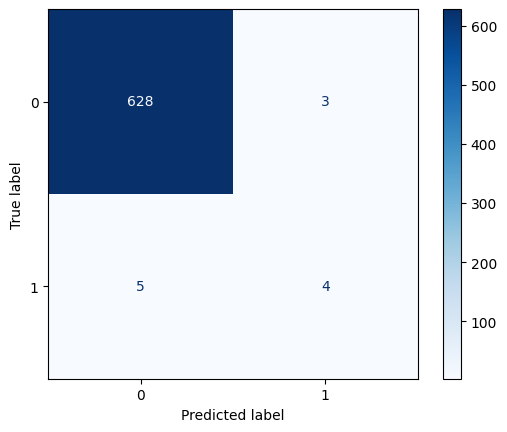

In [ ]:
# Tune SVM
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
svm_base_params = {
    'class_weight': {0: 1, 1: scale_pos_weight_adjusted},  # Use your adjusted weight
    'probability': True,   # Required for threshold tuning
    'random_state': 42
}
best_svm_model, best_svm_params, best_svm_score = tune_hyperparameters(
    SVC, svm_param_grid,
    X_train_tfidf, train_labels,
    train_idx_tfidf, val_idx_tfidf,
    svm_base_params
)

print(f"\nBest SVM Parameters: {best_svm_params}")

# Tune Threshold for SVM
svm_threshold, svm_metrics = tune_threshold(best_svm_model, X_train_tfidf, train_labels, train_idx_tfidf, val_idx_tfidf)
print(f"Best SVM Threshold: {svm_threshold:.3f}")
print(f"F1: {svm_metrics['f1']:.4f}, Precision: {svm_metrics['precision']:.4f}, Recall: {svm_metrics['recall']:.4f}")

# Get validation predictions with the best threshold
val_preds_proba = best_svm_model.predict_proba(X_train_tfidf[val_idx_tfidf])[:, 1]
val_preds_binary = (val_preds_proba >= svm_threshold).astype(int)

# Get true labels for validation set
val_true = train_labels[val_idx_tfidf]

# Generate Confusion Matrix
cm = confusion_matrix(val_true, val_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

# Log loss
val_log_loss = log_loss(val_true, val_preds_proba)
print(f"Log Loss: {val_log_loss:.4f}")

**Tune XGBoost with TF-IDF**


Best XGBoost Parameters: {'random_state': 42, 'scale_pos_weight': 0.35187604161974684, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best XGBoost Threshold: 0.600
F1: 0.5000, Precision: 0.5714, Recall: 0.4444
Log Loss: 0.0825


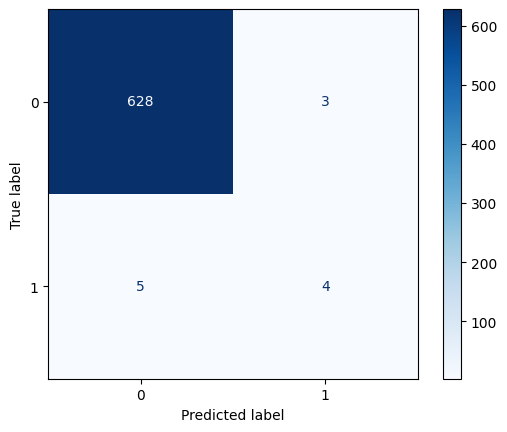

In [ ]:
# Tune XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300]
}
xgb_base_params = {
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight_adjusted
}
best_xgb_model, best_xgb_params, best_xgb_score = tune_hyperparameters(
    xgb.XGBClassifier, xgb_param_grid, X_train_tfidf, train_labels, train_idx_tfidf, val_idx_tfidf, xgb_base_params
)
print(f"\nBest XGBoost Parameters: {best_xgb_params}")

# Tune threshold for XGBoost
xgb_threshold, xgb_metrics = tune_threshold(best_xgb_model, X_train_tfidf, train_labels, train_idx_tfidf, val_idx_tfidf)
print(f"Best XGBoost Threshold: {xgb_threshold:.3f}")
print(f"F1: {xgb_metrics['f1']:.4f}, Precision: {xgb_metrics['precision']:.4f}, Recall: {xgb_metrics['recall']:.4f}")

# Get validation predictions with the best threshold
val_preds_proba = best_xgb_model.predict_proba(X_train_tfidf[val_idx_tfidf])[:, 1]
val_preds_binary = (val_preds_proba >= xgb_threshold).astype(int)

# Get true labels for validation set
val_true = train_labels[val_idx_tfidf]

# Generate Confusion Matrix
cm = confusion_matrix(val_true, val_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

# Log loss
val_log_loss = log_loss(val_true, val_preds_proba)
print(f"Log Loss: {val_log_loss:.4f}")

**Tune LightGBM with Combined Features**


Best LightGBM Parameters: {'random_state': 42, 'scale_pos_weight': 0.35187604161974684, 'verbose': -1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best LightGBM Threshold: 0.500
F1: 0.5833, Precision: 0.4667, Recall: 0.7778
Log Loss: 0.0650


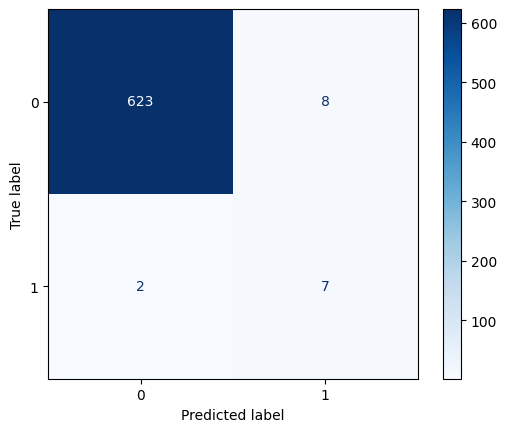

In [ ]:
# Tune LightGBM
lgb_param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300]
}
lgb_base_params = {
    'random_state': 42,
    'scale_pos_weight': scale_pos_weight_adjusted,
    'verbose': -1
}
best_lgb_model, best_lgb_params, best_lgb_score = tune_hyperparameters(
    lgb.LGBMClassifier, lgb_param_grid, X_train_combined, train_labels, train_idx_combined, val_idx_combined, lgb_base_params
)
print(f"\nBest LightGBM Parameters: {best_lgb_params}")

# Tune threshold for LightGBM
lgb_threshold, lgb_metrics = tune_threshold(best_lgb_model, X_train_combined, train_labels, train_idx_combined, val_idx_combined)
print(f"Best LightGBM Threshold: {lgb_threshold:.3f}")
print(f"F1: {lgb_metrics['f1']:.4f}, Precision: {lgb_metrics['precision']:.4f}, Recall: {lgb_metrics['recall']:.4f}")

# Get validation predictions with the best threshold
val_preds_proba = best_lgb_model.predict_proba(X_train_combined[val_idx_combined])[:, 1]
val_preds_binary = (val_preds_proba >= lgb_threshold).astype(int)

# Get true labels for validation set
val_true = train_labels[val_idx_combined]

# Generate Confusion Matrix
cm = confusion_matrix(val_true, val_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

# Log loss
val_log_loss = log_loss(val_true, val_preds_proba)
print(f"Log Loss: {val_log_loss:.4f}")

### 8 - Model Selection


---



LightGBM with combined features is selected primarily based on its:
- Highest F1 performance in model training
- Highest F1 performance in model tuning

LightGBM with combined features is consistently the top performer with the best F1 scores. It also has a relatively high recall and precision, and which it maintains after tuning on a realistic class imbalance. XGBoost is a close second, but LightGBM has higher F1 scores while still showing good recall and precision.

The F1 scores are a significant improvement on the baseline of 0.

**Scores after training (5-fold CV, balanced weights)**

In [ ]:
# Find feature representation and print
best_lgb_features = max(lgb_results, key=lambda k: lgb_results[k]["f1"])
print(f"F1: {lgb_results[best_lgb_features]['f1']:.4f}")
print(f"Recall: {lgb_results[best_lgb_features]['recall']:.4f}")
print(f"Precision: {lgb_results[best_lgb_features]['precision']:.4f}")


Best Features for LightGBM: Combined
F1: 0.7596
Recall: 0.6560
Precision: 0.9025


**Scores after tuning (on severe class imbalance)**

F1: 0.5833, Precision: 0.4667, Recall: 0.7778
Log Loss: 0.0650


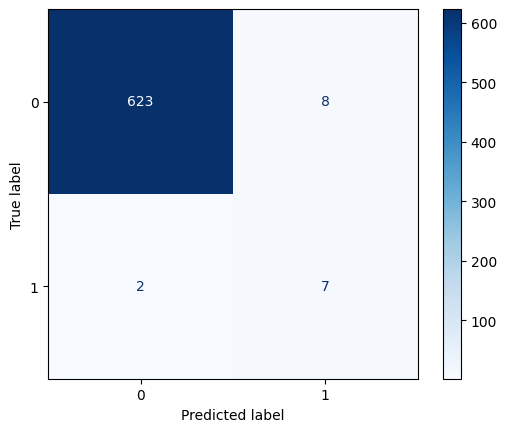

In [ ]:
print(f"F1: {lgb_metrics['f1']:.4f}, Precision: {lgb_metrics['precision']:.4f}, Recall: {lgb_metrics['recall']:.4f}")

# Generate Confusion Matrix
cm = confusion_matrix(val_true, val_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")

val_log_loss = log_loss(val_true, val_preds_proba)
print(f"Log Loss: {val_log_loss:.4f}")

### 9 - Model Evaluation


---

The best model, LightGBM with combined features, is retrained on the full training set with the optimal tuning found. It is then evaluated on the test set.

**Performance metrics on test set**

Final Evaluation on Test Set
              precision    recall  f1-score   support

           0     0.9924    0.9987    0.9956       788
           1     0.8571    0.5000    0.6316        12

    accuracy                         0.9912       800
   macro avg     0.9248    0.7494    0.8136       800
weighted avg     0.9904    0.9912    0.9901       800

Log Loss: 0.0348


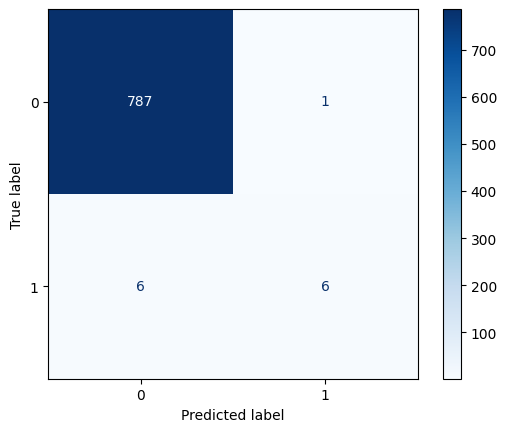

In [ ]:
# Rebuild the model with best hyperparameters
final_lgb_model = lgb.LGBMClassifier(**best_lgb_params)

# Retrain on the full training set
final_lgb_model.fit(X_train_combined, train_labels)

# Predict on test set
y_test_probs = final_lgb_model.predict_proba(X_test_combined)[:, 1]
y_test_preds = (y_test_probs >= lgb_threshold).astype(int)

# Output evaluation metrics on test set
print("Final Evaluation on Test Set")
print(classification_report(test_labels, y_test_preds, digits=4))
print(f"Log Loss: {log_loss(test_labels, y_test_probs):.4f}")

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(
    test_labels, y_test_preds, display_labels=[0, 1], cmap='Blues'
)

The final model performs well compared to the baseline naive classifier, which had an F1 score of 0. Especially given that outage posts are rare, making up only 1.5% of the test set and actual data, it achieves a respectable F1 score.It has high precision but moderate recall, indicating it misses half of the actual outages due to a potentially suboptimal threshold.

The low log loss reflects strong confidence in its predictions, and the confusion matrix shows it correctly identified 6 outage posts and 788 non-outage posts, while incorrectly labeling 7 outage posts.

**Misclassified posts**

In [ ]:
# Find misclassified posts
misclassified = np.where(y_test_preds != test_labels)[0]

# Create a DataFrame with misclassified posts
misclassified_df = pd.DataFrame({
    'Post_Text': test['Text'].iloc[misclassified],
    'True_Label': test_labels[misclassified],
    'Predicted_Label': y_test_preds[misclassified]
})

# Print results
print(f"Total misclassified: {len(misclassified)}")
print(misclassified_df)

Total misclassified: 7
                                             Post_Text  True_Label  \
138  I would like to see a larger option available,...           0   
230  Alissa Sanford mine is out too - so early in t...           1   
405  "didn't even get the full order  nobody called...           1   
566              refunded by the store out of product.           1   
758  Didnt get Bagel. Starbucks said no bagels in s...           1   
789  It wasn't the restraunt  it was just me  I usu...           1   
799  they should have taken it off their menu if it...           1   

     Predicted_Label  
138                1  
230                0  
405                0  
566                0  
758                0  
789                0  
799                0  


The model misclassified 7 posts, mostly missing product outage posts. Keywords like “is out too,” “store out of product,” and “Starbucks said no bagels,” the model missed highlights the model’s struggle to generalize across diverse expressions of outage-related content, possibly due to the limited representation of such cases in the training data.

Retraining the model with a larger, more varied dataset could improve its ability to accurately identify these outage posts by capturing a broader range of linguistic patterns.

### 9 - Active Learning


---

A small active learning test is performed to see if active learning will improve the best model's F1 score and other metrics.

In [ ]:
# Rerun code from start until Feature Engineering, then run this cell

# Combine train and test original indices
labeled_indices = set(train_df['original_index']).union(set(test_df['original_index']))

# Get all original indices from the combined_df
combined_df_indexed = combined_df.reset_index()
all_original_indices = set(combined_df_indexed['index'])

# Identify indices that are in combined_df but not in train_df or test_df
unlabeled_indices = list(all_original_indices - labeled_indices)

# Select the rows from the original combined_df using these indices
unlabeled_pool_df = combined_df.loc[unlabeled_indices].copy().reset_index(drop=True)

# Drop any helper columns
unlabeled_pool_df = unlabeled_pool_df.drop(columns=['text_lower', 'is_keyword_hit', 'char_count'], errors='ignore')

# Sample 1000 rows from the unlabeled pool
unlabeled_df = unlabeled_pool_df.sample(n=3000, random_state=42)

print(f"Size of the unlabeled pool for active learning: {len(unlabeled_df)}")

Size of the unlabeled pool for active learning: 3000


In [ ]:
# Preprocess text for TF-IDF (same as training)
def preprocess_text_for_phrasing(text):
    text = str(text).lower()                                          # Lowercase
    text = re.sub(r'http\S+', '', text)                               # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)                                      # Tokenize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]  # Lemmatize and remove stop words
    return tokens

# Apply preprocessing for TF-IDF
unlabeled_df['Text_tokens_al'] = unlabeled_df['Text'].apply(preprocess_text_for_phrasing)

# Apply phraser
unlabeled_df['Text_phrased_al'] = unlabeled_df['Text_tokens_al'].apply(lambda tokens: phraser[tokens])

# Rejoin tokens for TF-IDF
unlabeled_df['Text_tfidf_al'] = unlabeled_df['Text_phrased_al'].apply(lambda tokens: ' '.join(tokens))

# Transform the text data using the fitted TF-IDF vectorizer
X_unlabeled_tfidf = tfidf_vectorizer.transform(unlabeled_df['Text_tfidf_al']).toarray()

# Generate BERT embeddings for unlabeled data
print("Generating BERT embeddings for unlabeled data...")
X_unlabeled_bert = get_bert_embeddings(unlabeled_df['Text'])

# Normalize BERT embeddings using the same scaler as training
X_unlabeled_bert = scaler.transform(X_unlabeled_bert)

# Combine TF-IDF and BERT embeddings
X_unlabeled_combined = np.concatenate((X_unlabeled_bert, X_unlabeled_tfidf), axis=1)

# Predict probabilities on the unlabeled data using the trained LightGBM model
y_unlabeled_proba = final_lgb_model.predict_proba(X_unlabeled_combined)[:, 1]

# Add probabilities and predictions to the unlabeled dataframe
unlabeled_df['predicted_proba_1'] = y_unlabeled_proba

# Use the best threshold found earlier for the final prediction
unlabeled_df['Label'] = (y_unlabeled_proba >= lgb_threshold).astype(int)

# Filter for instances with predicted label 1 or high uncertainty (probability near 0.5)
uncertainty_threshold = 0.1  # Define a range around 0.5 for uncertainty
uncertain_or_class_1 = unlabeled_df[
    (unlabeled_df['Label'] == 1) |
    ((unlabeled_df['predicted_proba_1'] > (0.5 - uncertainty_threshold)) &
     (unlabeled_df['predicted_proba_1'] < (0.5 + uncertainty_threshold)))
].copy()

print(f"Number of uncertain or class 1 predictions for manual labeling: {len(uncertain_or_class_1)}")
display(uncertain_or_class_1[['Text', 'predicted_proba_1', 'Label']])

# Define the path to save the file
drive_path = '/content/drive/My Drive/'

# Select columns for manual labeling and export to Excel
cols_to_export_al = ['Text', 'Label']
uncertain_or_class_1[cols_to_export_al].to_excel(drive_path + 'active_learning_for_labeling.xlsx', index=False)

Generating BERT embeddings for unlabeled data...


Generating BERT embeddings: 100%|██████████| 188/188 [28:21<00:00,  9.05s/it]


Number of uncertain or class 1 predictions for manual labeling: 42


,Text,predicted_proba_1,Label
110506,Didn't give correct items. Had to sub out caus...,0.891741,1
9979,Starbucks is this available in Canada too?,0.634263,1
58109,Cant even give your Burnt coffee away!!! Lets ...,0.723355,1
118856,was not available. had to substitute.,0.985256,1
72680,Out of stock not delivered,0.999645,1
74386,Didn't have enough coconut milk or fruit.,0.826852,1
83854,they didn't have it,0.944406,1
876,"Yummy, looks good !!! Might have to check it o...",0.401582,0
93397,Didn't add white mocha pumps but was charged,0.579683,1
106644,Ordered two sandwiches but only received one. ...,0.725765,1


In [ ]:
# Read in manually labeled datasets
path = '/content/drive/My Drive/Labeled_Data/'
labeled_active_learning = pd.read_excel(path + 'active_learning_labeled.xlsx')
labeled_active_learning_subset = labeled_active_learning[['Text', 'Label']].copy()

# Combine the original training set with the manually labeled active learning data
train_new = pd.concat([train[['Text', 'Label']], labeled_active_learning_subset], ignore_index=True)

# Preprocess updated training data
train_new_tokens = train_new['Text'].apply(preprocess_text_for_phrasing)
train_new_phrased = train_new_tokens.apply(lambda tokens: phraser[tokens])
train_new['Text_tfidf'] = train_new_phrased.apply(lambda tokens: ' '.join(tokens))

# Use the same fitted TF-IDF vectorizer
X_train_new_tfidf = tfidf_vectorizer.transform(train_new['Text_tfidf']).toarray()

# Get BERT embeddings and use the same fitted scaler
print("Generating BERT embeddings for updated training data...")
X_train_new_bert = get_bert_embeddings(train_new['Text'])
X_train_new_bert = scaler.transform(X_train_new_bert)

# Combine embeddings
X_train_new_combined = np.concatenate((X_train_new_bert, X_train_new_tfidf), axis=1)
print(f"Updated combined training features shape: {X_train_new_combined.shape}")

Generating BERT embeddings for updated training data...


Generating BERT embeddings: 100%|██████████| 203/203 [28:26<00:00,  8.41s/it]

Updated combined training features shape: (3242, 3419)



 Evaluation on Test Set AFTER Active Learning
              precision    recall  f1-score   support

           0     0.9924    0.9987    0.9956       788
           1     0.8571    0.5000    0.6316        12

    accuracy                         0.9912       800
   macro avg     0.9248    0.7494    0.8136       800
weighted avg     0.9904    0.9912    0.9901       800

Log Loss: 0.0340


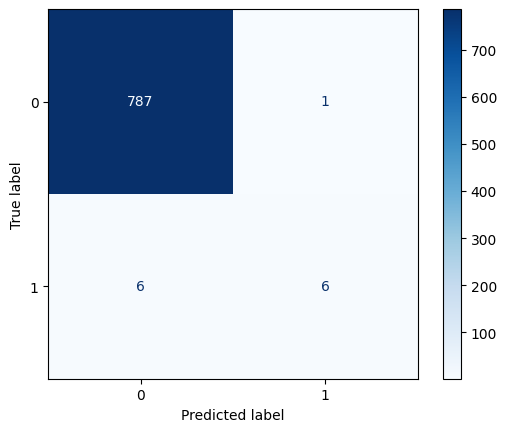

In [ ]:
# Retrain LightGBM using best hyperparameters
final_lgb_model_active = lgb.LGBMClassifier(**best_lgb_params)
final_lgb_model_active.fit(X_train_new_combined, train_new['Label'])

# Predict on the original test set (same as before)
y_test_probs_active = final_lgb_model_active.predict_proba(X_test_combined)[:, 1]
y_test_preds_active = (y_test_probs_active >= lgb_threshold).astype(int)

# Evaluate model after active learning
print("\n Evaluation on Test Set AFTER Active Learning")
print(classification_report(test_labels, y_test_preds_active, digits=4))
print(f"Log Loss: {log_loss(test_labels, y_test_probs_active):.4f}")

# Show confusion matrix
ConfusionMatrixDisplay.from_predictions(
    test_labels, y_test_preds_active, display_labels=[0, 1], cmap='Blues'
)

Active learning did not improve the model's performance on the test set. This is likely due to the size of the used in this test. While it did not improve performance, this code can be used as a framework for Starbucks to test with larger amounts of data.

### 9 - User-interface integration


---

For deployment on the web application, the following are saved:
- Best model
- Best feature engineering method

**Save objects**

In [ ]:
import joblib
import os

# Define the path to save the model file in Google Drive
drive_path = '/content/drive/My Drive/'
os.makedirs(drive_path, exist_ok=True)

# Save model
final_model = final_lgb_model
joblib.dump(final_model, drive_path + 'lgb_model.pkl', compress = 1)

# Save feature engineering
joblib.dump(phraser, drive_path + 'phraser.pkl')
joblib.dump(tfidf_vectorizer, drive_path + 'tfidf_vectorizer.pkl')
joblib.dump(scaler, drive_path + 'bert_scaler.pkl')

['/content/drive/My Drive/bert_scaler.pkl']